In [20]:
%load_ext autoreload
%autoreload 2
import numpy as np
from source.read_HAR_dataset import DatasetHARUML20
from source.read_pamap2 import DatasetPAMAP2
from source.tserie import TSerie
from source.models.manifold.umap_fl import UMAP_FL
from sklearn import metrics
from xgboost import XGBClassifier
from source.utils import MetricsSaver, saveConfusionMatrix
from sklearn.metrics import confusion_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# dataset = DatasetHARUML20(mode = 'leave-one-subject')
dataset = DatasetPAMAP2(mode = 'leave-one-subject', signals=['handAcc16_1', 'handAcc16_2', 'handAcc16_3', 'handGyro1', 'handGyro2', 'handGyro3'])

saver = MetricsSaver('PAMAP2', rows = ['train', 'test'], cols=['F1-score', 'Balanced Accuracy', 'Accuracy'])

In [3]:
predicted_classes = []
real_classes = []
while dataset.loadData():
    
    # Preparing data
    ts_train = TSerie(dataset.X_train, dataset.Int_train)
    ts_test = TSerie(dataset.X_test, dataset.Int_test)
    ts_train.center()
    ts_test.center()
    ts_train.folding_features_v2()
    ts_test.folding_features_v2()
    
    
    # Getting features
    model = UMAP_FL(n_components=32,n_neighbors=15, n_epochs=1000)
    ts_train.features = model.fit_transform(ts_train.features, y=ts_train.y)
    ts_test.features = model.transform(ts_test.features)
    
    
    # Classifying
    clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
    clf.fit(ts_train.features, ts_train.y)
    train_pr = clf.predict(ts_train.features)
    test_pr = clf.predict(ts_test.features)
    predicted_classes.append(test_pr)
    real_classes.append(ts_test.y)


    # Save metrics
    train_f1 = metrics.f1_score(ts_train.y, train_pr, average='weighted')
    test_f1 = metrics.f1_score(ts_test.y, test_pr, average='weighted')
    train_bacc = metrics.balanced_accuracy_score(ts_train.y, train_pr)
    test_bacc = metrics.balanced_accuracy_score(ts_test.y, test_pr)
    train_acc = metrics.accuracy_score(ts_train.y, train_pr)
    test_acc = metrics.accuracy_score(ts_test.y, test_pr)
    
    saver.addLog('train', 'F1-score', train_f1)
    saver.addLog('test', 'F1-score', test_f1)
    saver.addLog('train', 'Balanced Accuracy', train_bacc)
    saver.addLog('test', 'Balanced Accuracy', test_bacc)
    saver.addLog('train', 'Accuracy', train_acc)
    saver.addLog('test', 'Accuracy', test_acc)
    
predicted_classes = np.concatenate(predicted_classes, axis = 0)
real_classes = np.concatenate(real_classes, axis = 0)

/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [18]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# cm = confusion_matrix(real_classes, predicted_classes)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, ) # display_labels= activities[2:]
# disp.plot()

saveConfusionMatrix(real_classes, predicted_classes)

NameError: name 'saveConfusionMatrix' is not defined

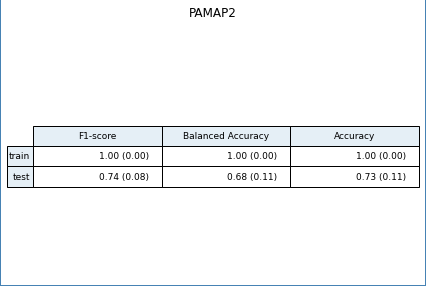

In [16]:
saver.toImage()

In [4]:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# dataset.y_train = le.fit_transform(dataset.y_train)
# dataset.y_test = le.transform(dataset.y_test)


/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [9]:
saver.logs

{'train': {'F1-score': [1.0], 'Balanced Accuracy': [1.0]},
 'test': {'F1-score': [0.6993691019633683],
  'Balanced Accuracy': [0.7219047619047618]}}

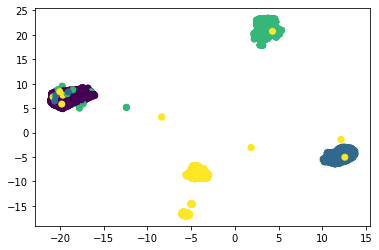

In [15]:
import matplotlib.pyplot as plt

plt.scatter(ts_train.features[:,0], ts_train.features[:,1], c=ts_train.y)



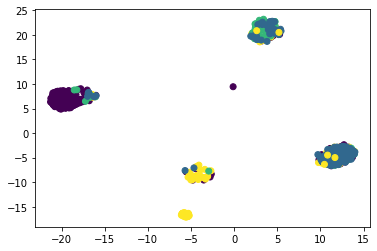

In [16]:
plt.scatter(ts_test.features[:,0], ts_test.features[:,1], c=ts_test.y)

In [11]:
np.unique(ts_train.y)

array([ 1,  2,  3,  4,  5,  6,  7, 12, 13, 16, 17, 24], dtype=int32)